In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvx_portfolio as cp

plotdir = '../portfolio/plots/'

## Download data using ee103 code (to be integrated) 

In [2]:
datadir= '../equity_data_tool/'
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])

a = pd.DataFrame(data=2.5*1e-4, index=volumes.index, columns=volumes.columns)
b = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns) # fix volatility model
s = pd.DataFrame(data=1*1e-4, index=volumes.index, columns=volumes.columns)

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

np.random.seed(0)
noise=pd.DataFrame(index=returns.index, columns=returns.columns, 
                   data=0.1*np.random.randn(*returns.values.shape))
return_estimate= returns + noise
return_estimate.USDOLLAR = returns.USDOLLAR
alpha_model = cp.AlphaSource(return_estimate)

In [3]:
# np.random.seed(1)
# alpha_signal=generate_alpha_signal(real_returns=returns, IC=0.01, type_noise='OU')
# alpha_signal.USDOLLAR = returns.USDOLLAR
# alpha_model = AlphaSource(alpha_signal)

In [4]:
simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

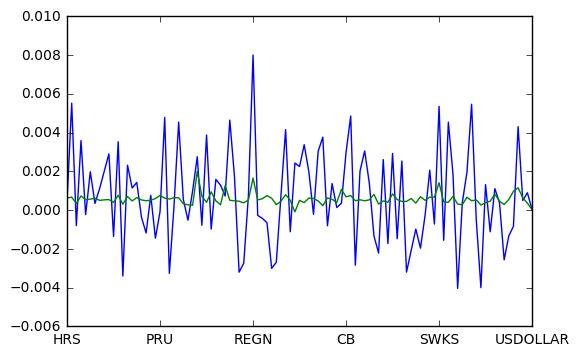

In [5]:
return_estimate.mean().plot()
returns.mean().plot()

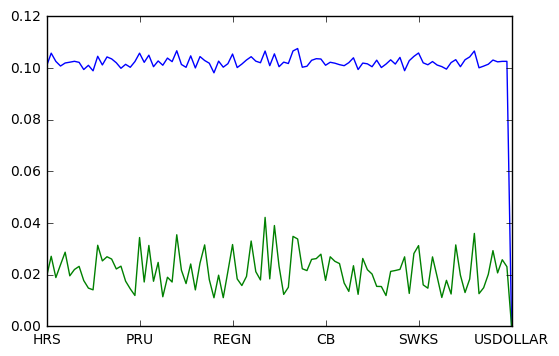

In [6]:
return_estimate.std().plot()
returns.std().plot()

In [7]:
return_estimate.min().min()

-0.52859176531801166

### Simulations

In [8]:
all_results={}

In [9]:
from cvx_portfolio.data import series_factor_model_covariance
exposures_pan, factor_sigma_pan, idyos_df = series_factor_model_covariance(returns, variance_explained=.75,
                                                                           freq='MS',lookback_periods = 12)
risk_model = cp.FactorModelSigma(exposures_pan, factor_sigma_pan, idyos_df)

policies={}
gamma_risks=[ 10., 100., 1000.]
gamma_tcosts=[10., 100., 1000.] # only 0 1 60 70
for gamma_risk in gamma_risks:
    for gamma_tcost in gamma_tcosts : 
        policies[(gamma_risk, gamma_tcost)] = \
                cp.SinglePeriodOpt(alpha_model, [gamma_risk*risk_model, gamma_tcost*simulated_tcost],
                                                #simulated_hcost], 
                                [cp.LeverageLimit(3)])

## Simulations

In [10]:
results=dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True)))

In [11]:
# temp
all_results.update(results)
results = all_results

result_df=pd.DataFrame()
for k in all_results:
    result_df.loc[k[0], k[1]] = all_results[k]
result_df.index.name = 'gamma_risk'
result_df.columns.name = 'gamma_tcost'
result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))


In [12]:
used_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)]
benchmark_returns = pd.Series(index=used_returns.index, data=used_returns.USDOLLAR)

result_df_used= result_df#[[0.,10., 15., 20.]]

table=pd.DataFrame()
table[r'Excess return']=\
result_df_used.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
table[r'Transaction costs']=\
    result_df_used.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()
table[r'Excess risk']= \
    result_df_used.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()



# format index
table=table.set_index(table.index.set_levels([["%g"%i for i in table.index.levels[0]],
                      ["%g"%i for i in table.index.levels[1]]]))


table_print=pd.DataFrame(table,copy=True)
table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )
print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

\begin{tabular}{lllll}
\toprule
   &    & Excess return & Transaction costs & Excess risk \\
gamma_tcost & gamma_risk &               &                   &             \\
\midrule
10 & 10 &        -8.63\% &           427.42\% &      79.38\% \\
   & 100 &       -25.55\% &           345.59\% &      54.51\% \\
   & 1000 &       -38.23\% &           237.08\% &      28.81\% \\
100 & 10 &        19.44\% &            59.33\% &      31.07\% \\
   & 100 &        16.95\% &            56.37\% &      18.12\% \\
   & 1000 &        10.74\% &            44.54\% &       8.87\% \\
1000 & 10 &        24.85\% &             0.14\% &      33.95\% \\
   & 100 &        16.86\% &             0.00\% &      14.16\% \\
   & 1000 &         6.03\% &             0.02\% &       7.38\% \\
\bottomrule
\end{tabular}



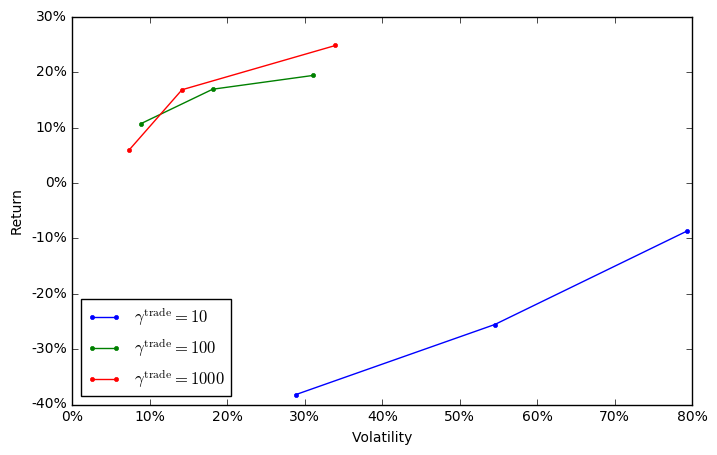

In [16]:
plt.figure(figsize=(8,5))
for gamma_tcost in table.index.levels[0][:]:
    x = table.loc[gamma_tcost]['Excess risk']
    y = table.loc[gamma_tcost]['Excess return']
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %s$'%gamma_tcost)
plt.legend(loc='lower left')
plt.xlabel('Volatility')
plt.ylabel('Return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'spo_riskrewardfrontier.png')

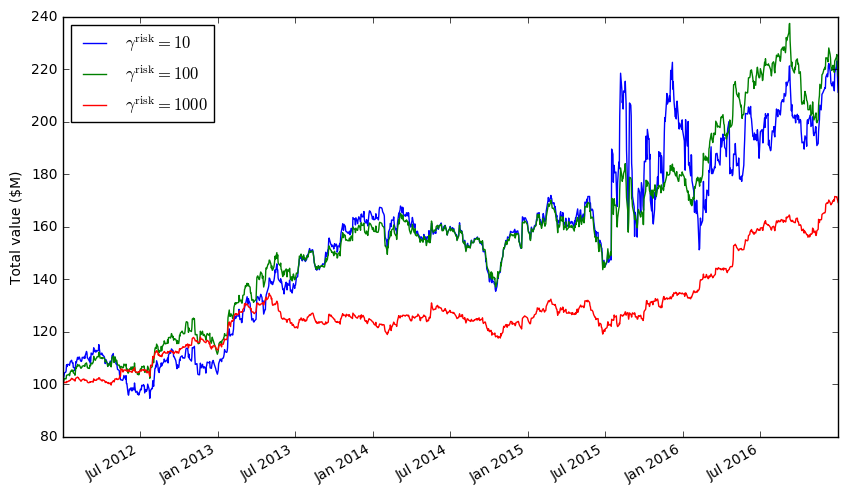

In [17]:
gamma_tcost=100#gamma_tcosts[2]
plt.figure(figsize=(10,6))

[(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^\mathrm{risk} = %g$'%i) for i in gamma_risks]
plt.legend(loc='upper left')# if i==0 else 'upper left')
plt.ylabel('Total value (\$M)')
plt.savefig(plotdir+'spo_valueintime.png')

In [18]:
sigmas.values[:,:-1]

array([[ 0.01783 ,  0.01093 ,  0.01346 , ...,  0.02703 ,  0.009036,
         0.01951 ],
       [ 0.02135 ,  0.009701,  0.01055 , ...,  0.01239 ,  0.007504,
         0.01433 ],
       [ 0.01145 ,  0.008481,  0.008176, ...,  0.01044 ,  0.01183 ,
         0.008382],
       ..., 
       [ 0.003367,  0.00795 ,  0.008313, ...,  0.007696,  0.01344 ,
         0.005273],
       [ 0.004203,  0.004313,  0.005057, ...,  0.003029,  0.004986,
         0.005032],
       [ 0.007097,  0.009721,  0.007199, ...,  0.007551,  0.007757,
         0.005731]])

(array([  2.51664000e+05,   1.14000000e+02,   9.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 0.     ,  0.01225,  0.0245 ,  0.03675,  0.049  ,  0.06125,
         0.0735 ,  0.08575,  0.098  ,  0.11025,  0.1225 ]),
 <a list of 10 Patch objects>)

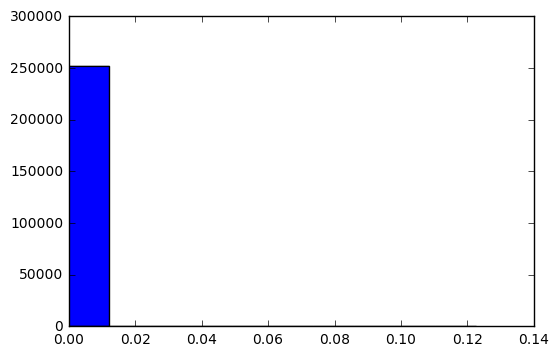

In [19]:
plt.hist(sigmas.values[:,:-1].flatten()**2)

In [20]:
result_df.applymap(lambda x: x.sharpe_ratio)

gamma_tcost,10.0,100.0,1000.0
gamma_risk,,,
10.0,-0.109118,0.628320,0.734965
100.0,-0.470629,0.939376,1.195253
1000.0,-1.332461,1.215444,0.821335


In [21]:
result_df.applymap(lambda x: x.policy_time.mean() + x.simulation_time.mean())

gamma_tcost,10.0,100.0,1000.0
gamma_risk,,,
10.0,0.038360,0.140814,0.143197
100.0,0.125212,0.139491,0.142626
1000.0,0.130659,0.139152,0.146621


In [22]:
result_df.applymap(lambda x: x.policy_time.sum() + x.simulation_time.sum())

gamma_tcost,10.0,100.0,1000.0
gamma_risk,,,
10.0,48.257264,177.143780,180.142237
100.0,157.517319,175.479572,179.423156
1000.0,164.368629,175.053666,184.448689


In [ ]:
# for i in range(4):
#     gamma_tcost = gamma_tcosts[i]
#     plt.figure(figsize=(10,5))
#     [(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^{risk} = %.2f$'%i) for i in gamma_risks]
#     plt.legend(loc='upper right' if i==0 else 'upper left')
#     plt.ylabel('portfolio value (\$M)')
#     plt.title('Portfolio value over time for $\gamma^{trade} = %.2f$'%gamma_tcost)
#     plt.savefig(plotdir+'spo_valueintime_gammatrade%d.png'%i)

In [ ]:
# for i in range(4):
#     gamma_tcost = gamma_tcosts[i]
#     plt.figure(figsize=(10,5))
#     [(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^{risk} = %.2f$'%i) for i in gamma_risks]
#     plt.legend(loc='upper right' if i==0 else 'upper left')
#     plt.ylabel('portfolio value (\$M)')
#     plt.title('Portfolio value over time for $\gamma^{trade} = %.2f$'%gamma_tcost)
#     plt.savefig(plotdir+'spo_valueintime_gammatrade%d.png'%i)

## Other diagnostics

In [ ]:
gamma_tcost=gamma_tcosts[-1]
[(np.sqrt(250)*np.sqrt(results[(i, gamma_tcost)].policy_FactorModelSigma)).plot() for i in gamma_risks]
gamma_risks, gamma_tcost

In [ ]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [ ]:
[results[(i, gamma_tcosts[1])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[1]

In [ ]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [ ]:
[results[(i, gamma_tcosts[2])].w.USDOLLAR.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [ ]:
[results[(i, gamma_tcosts[2])].turnover.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [ ]:
res.turnover.plot()
res.policy_TcostModel.sum(1).plot(secondary_y=True)

In [ ]:
res.policy_TcostModel.sum(1).plot()
res.simulator_TcostModel.sum(1).plot(secondary_y=True)

In [ ]:
(res.policy_TcostModel.sum(1)).tail(100).plot(style='.-')
(res.simulator_TcostModel.sum(1)/res.v).tail(100).plot(style='.-')